In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
from lie.SE23 import *
from flowpipe.inner_bound import *
from flowpipe.outer_bound import *
from flowpipe.flowpipe import *
from sim.multirotor_plan import *

Generate smooth path

In [2]:
n_legs = 10
poly_deg = 7
min_deriv = 4  # min snap
bc_deriv = 4
cost = find_cost_function(
    poly_deg=poly_deg,
    min_deriv=min_deriv,
    rows_free=[],
    n_legs=n_legs,
    bc_deriv=bc_deriv,
)
k_time = 1e3
bc_land = np.array(
        [  # boundary conditions
            [
                [30, 0, 5],
                [27, 0, 4.5],
                [24, 0, 4],
                [21, 0, 3.5],
                [18, 0, 3],
                [15, 0, 2.5],
                [12, 0, 2],
                [9, 0, 1.5],
                [6, 0, 1],
                [3, 0, 0.5],
                [0, 0, 0]
            ],  # pos
            [
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [-0.3, 0, -0.05],
                [0, 0, 0]
            ],  # vel
            [
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]
            ],  # acc
            [
                [0, 0, 0], 
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]
            ],
        ]  # jerk
    )
# solve for bezier trajectories
ref_land = planner(bc_land, cost, n_legs, poly_deg, k_time)

T_opt [2.26915551 2.26915551 2.26915551 2.26915539 2.26915538 2.26915539
 2.26915536 2.26915548 2.26915548 2.32768924]


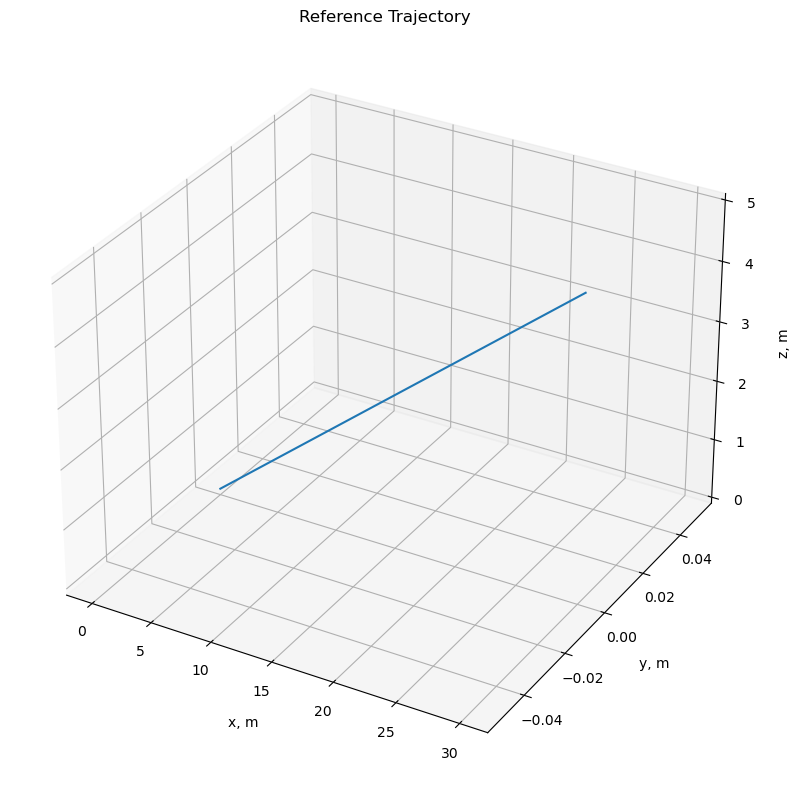

In [3]:
fig = plt.figure(figsize=(8,8))
traj_x = compute_trajectory(ref_land['x'], ref_land['T'], poly_deg=poly_deg, deriv=0) # points
traj_y = compute_trajectory(ref_land['y'], ref_land['T'], poly_deg=poly_deg, deriv=0)
traj_z = compute_trajectory(ref_land['z'], ref_land['T'], poly_deg=poly_deg, deriv=0)
ax = fig.add_subplot(111, projection="3d")
ax.plot(ref_land["x"], ref_land["y"], ref_land["z"]);
ax.set_xlabel('x, m', labelpad=10)
ax.set_ylabel('y, m', labelpad=12)
ax.set_zlabel('z, m', rotation=90, labelpad=8)
ax.set_title('Reference Trajectory')
plt.axis('auto')
plt.tight_layout()

In [4]:
ax_land = [np.max(ref_land['ax'])]
ay_land = [np.max(ref_land['ay'])]
az_land = [np.max(ref_land['az'])-9.8]
omega1_land = [np.max(ref_land['omega1'])]
omega2_land = [np.max(ref_land['omega2'])]
omega3_land = [np.max(ref_land['omega3'])]

In [5]:
# Set disturbance here
w1 = 0.1 # disturbance for translational
w2 = 0.01 # disturbance for angular

# Find bound for $\omega$

In [6]:
# solve LMI
sol = find_omega_invariant_set(omega1_land, omega2_land, omega3_land) 

# Initial condition
P = sol['P']
e0 = np.array([0,0,0]) # initial error
beta = (e0.T@P@e0) # initial Lyapnov value

# find bound
omegabound = omega_bound(omega1_land, omega2_land, omega3_land, w2, beta) # result for inner bound
print(omegabound)

0.003162277662373381


# Find outer bound (bound for $x-y-z$)

In [7]:
# solve LMI
sol_LMI_land = find_se23_invariant_set(ax_land, ay_land, az_land, omega1_land, omega2_land, omega3_land)

0.4
optimal


In [8]:
# Initial condition
e = np.array([0,0,0,0,0,0,0,0,0]) # initial error in Lie group (nonlinear)

# transfer initial error to Lie algebra (linear)
e0 = ca.DM(SE23Dcm.vee(SE23Dcm.log(SE23Dcm.matrix(e))))
e0 = np.array([e0]).reshape(9,)
ebeta = e0.T@sol_LMI_land['P']@e0

# find invairant set points in Lie algebra (linear)
points, val = se23_invariant_set_points(sol_LMI_land, 20, w1, omegabound, ebeta)
points_theta, val = se23_invariant_set_points_theta(sol_LMI_land, 20, w1, omegabound, ebeta)

In [9]:
# map invariant set points to Lie group (nonlinear)
inv_points = exp_map(points, points_theta)

Visualize Invariant Set

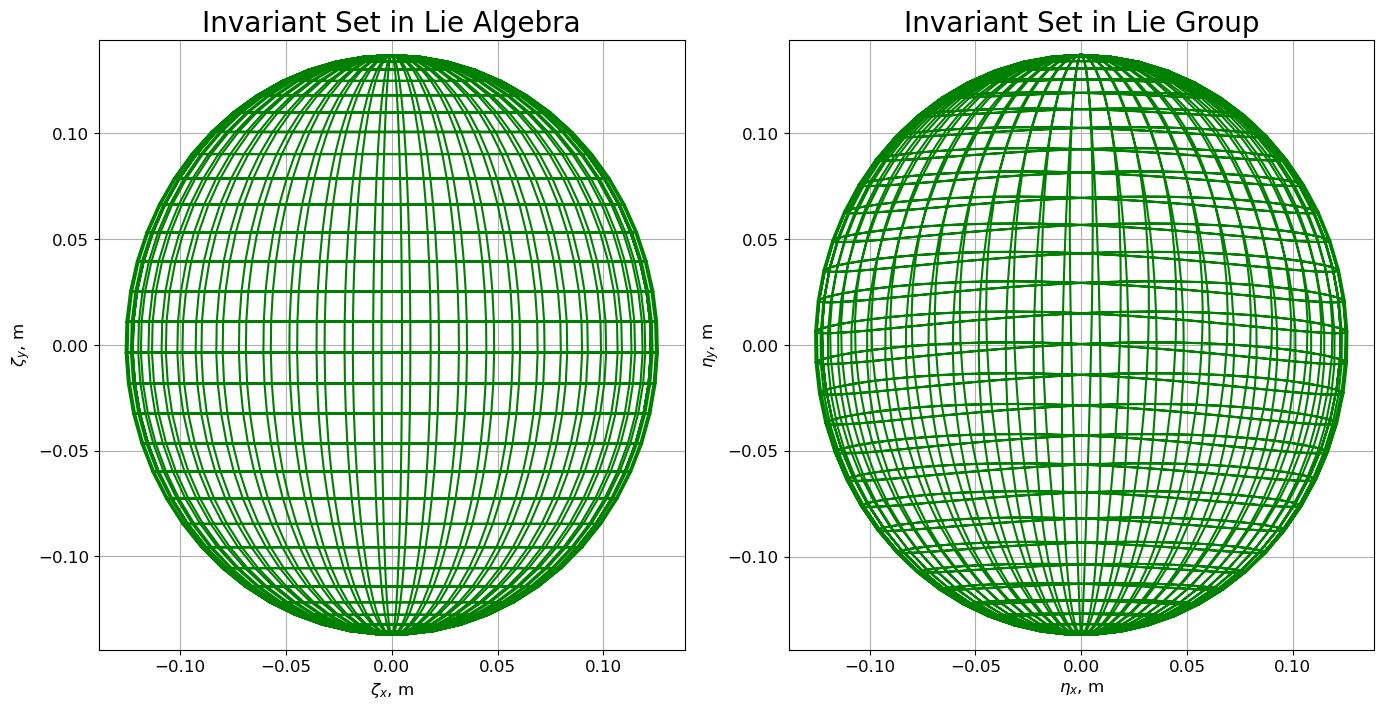

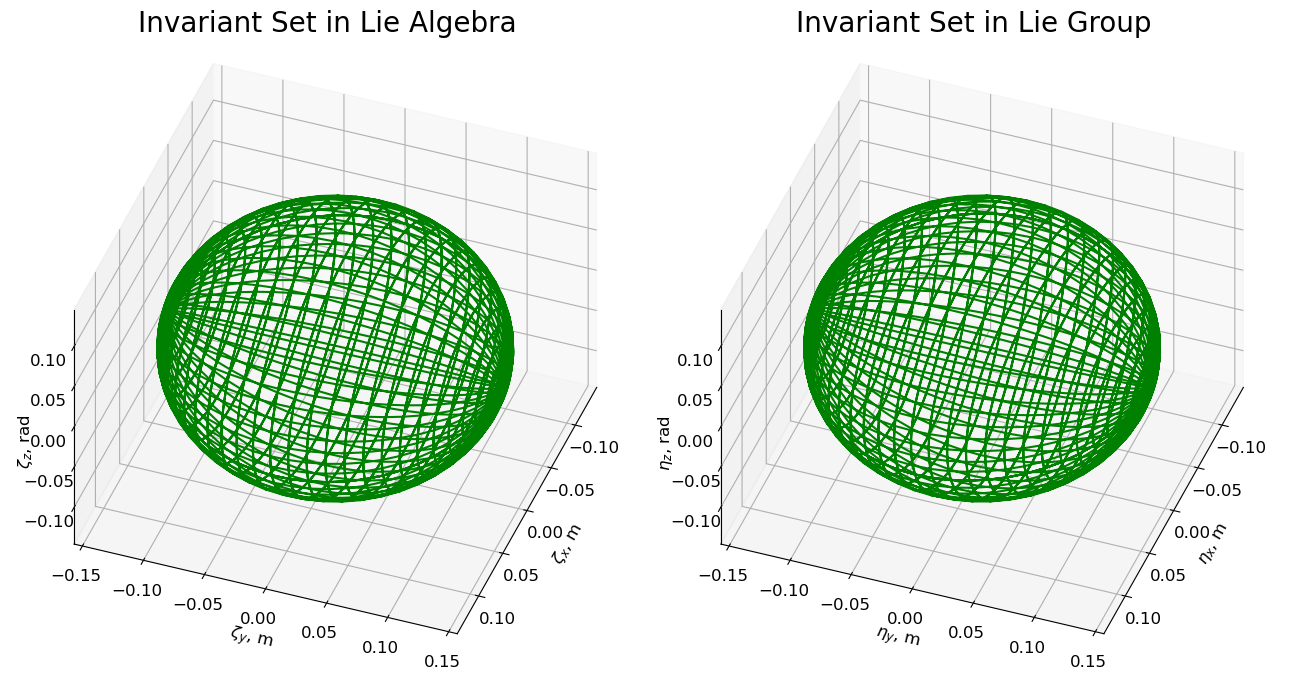

In [10]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 12})
ax1 = plt.subplot(121)
ax1.plot(points[0, :], points[1, :], 'g', label='with Dynamic Inversion')
# ax.plot(pointscl[0, :], pointscl[1, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\zeta_x$, m')
ax1.set_ylabel('$\\zeta_y$, m')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
# plt.legend(loc=1)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g', label='with Dynamic Inversion')
# ax2.plot(inv_pointscl[0, :-1], inv_pointscl[1, :-1], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
plt.grid(True)
# plt.legend(loc=1)
plt.axis('equal')
plt.tight_layout()
ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)
ax2.set_title('Invariant Set in Lie Group', fontsize=20)
# plt.savefig('figures/Invariant_l.eps', format='eps', bbox_inches='tight')

plt.figure(figsize=(14,7))
ax1 = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax1.plot3D(points[0, :], points[1, :], points[2, :],'g', label='with Dynamic Inversion')
# ax.plot3D(pointscl[0, :], pointscl[1, :], pointscl[2, :],'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\zeta_x$, m')
ax1.set_ylabel('$\\zeta_y$, m')
ax1.set_zlabel('$\\zeta_z$, rad', labelpad=1)
ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)
# plt.subplots_adjust(left=9, right=10, top=0.5, bottom=0.08)
# plt.tight_layout()
plt.axis('auto')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.legend(loc=1)
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g', label='with Dynamic Inversion')
# ax2.plot3D(inv_pointscl[0, :], inv_pointscl[1, :], inv_pointscl[2, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
ax2.set_zlabel('$\\eta_z$, rad')
ax2.set_title('Invariant Set in Lie Group', fontsize=20)
plt.axis('auto')
plt.subplots_adjust(left=0.45, right=1, top=0.5, bottom=0.08)
# plt.legend(loc=1)
plt.tight_layout()
# plt.savefig('figures/Invariant3d_l.eps', format='eps', bbox_inches='tight')

# Flow Pipes

In [11]:
from flowpipe.flowpipe import *
from sim.multirotor_control import *

In [12]:
# Calculate convex hull for flow pipes
n_pipes = 20
flowpipes_land, intervalhull_land, nom_land, t_vect = flowpipes(ref_land, n_pipes, ebeta, w1, omegabound, sol_LMI_land, 'xz')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


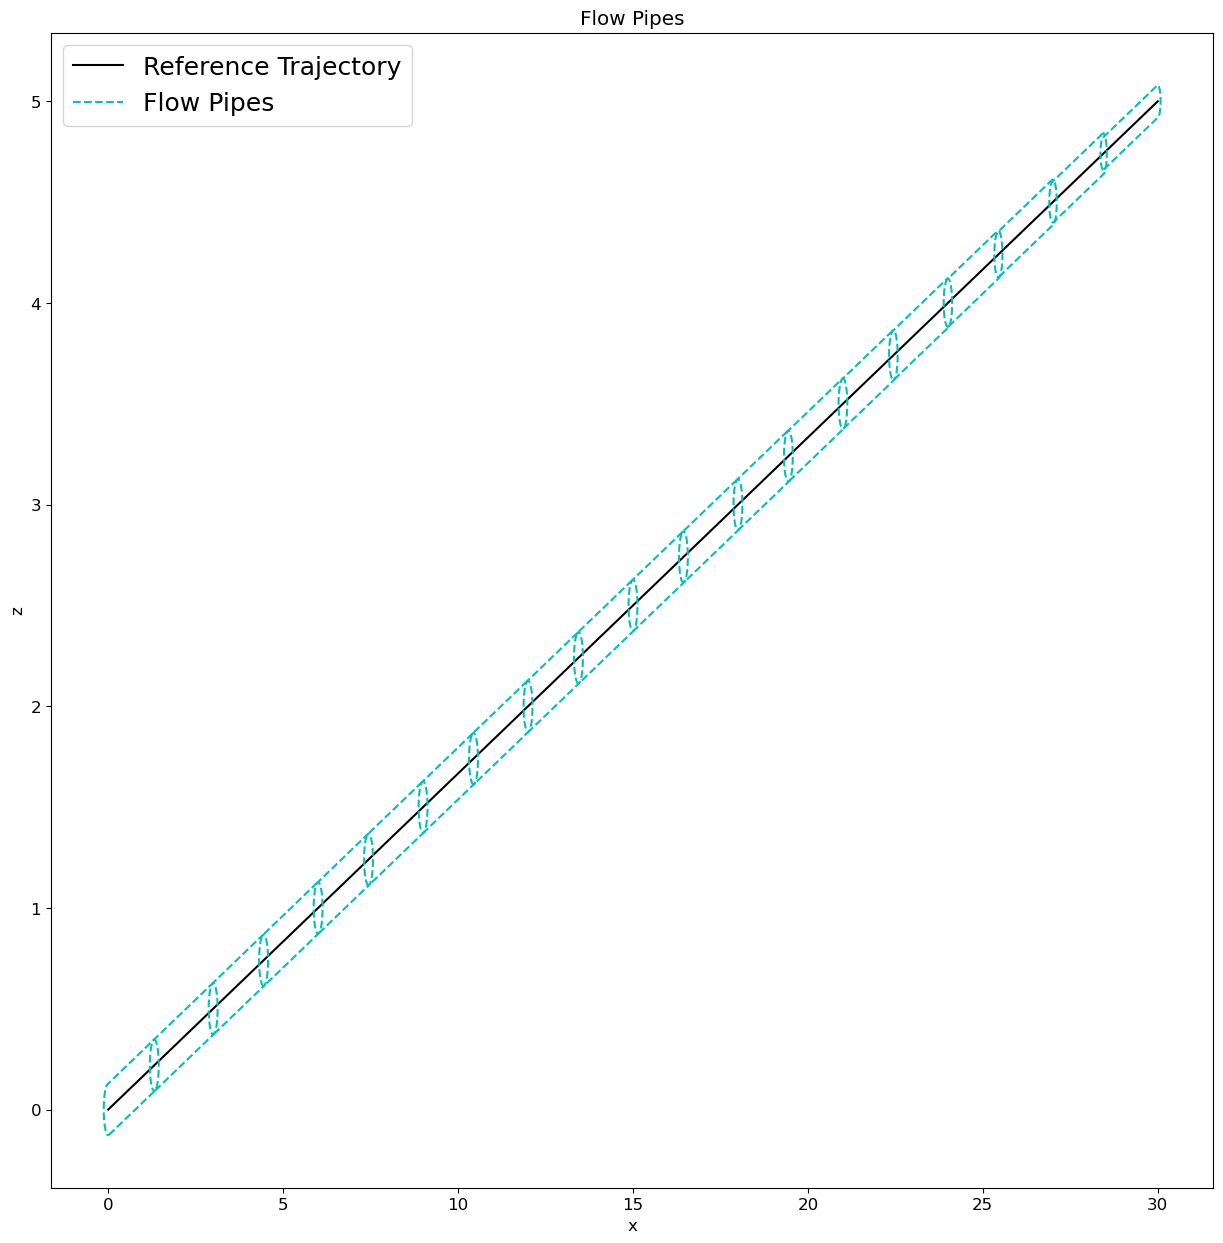

In [14]:
plot_flowpipes(nom_land, flowpipes_land, n_pipes, 'xz')

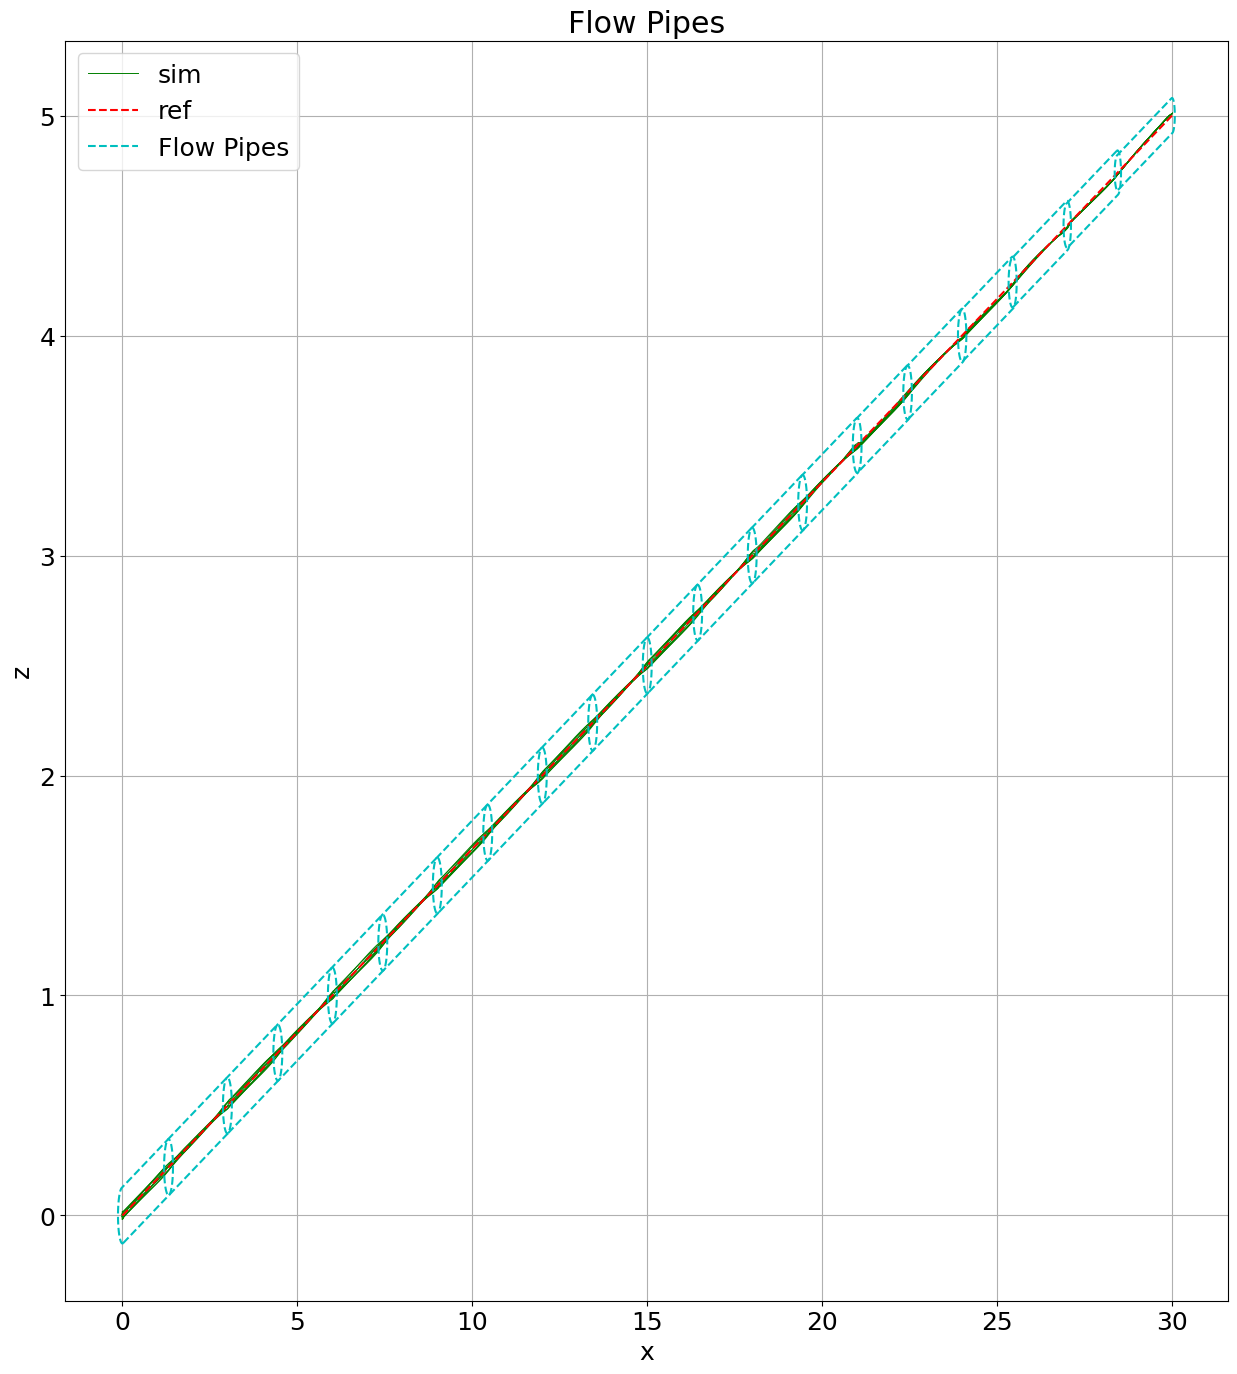

In [15]:
plot_sim(ref_land, w1, omegabound, flowpipes_land, n_pipes, 'xz')